# Info

(1) 2019-03: 15-18  

# Imports

In [4]:
import hysplit_py
import os
from hysplit_py import land_use_map as lume
import pathlib
import numpy as np
import matplotlib.pylab as plt
import atmPy # this is only because of the basemap import problem
from mpl_toolkits.basemap import Basemap
import xarray as xr
import copy

In [5]:
plt.rcParams['figure.dpi'] = 150

# Helpers

In [6]:
def row2fname_out(row):
    sdt = row.start_datetime
    namecomps = []
    
    namecomps.append(f'{sdt.year}{sdt.month:02d}{sdt.day:02d}_{sdt.hour:02d}{sdt.minute:02d}{sdt.second:02d}')    
    namecomps.append(f'{row.altitude}m')
    namecomps.append(row.hy_mode)

    fname = '_'.join(namecomps)
    fname += '.nc'
    return fname

# settings

In [118]:
process_number = 0 # between 1 and 6; 0 is for testing 
run_time =  - 3 #10 * 24
save_base_folder = '/mnt/telg/tmp/hysplit_test/'
coordinates_lat_lon = (40.12498, -105.23680) # Table mountain, CO
altitude = [100,] # reception altitudes
hysplit_mode = ['traj', 
#                 'conc'
                     ]
meterologic_data_format = 'gdas0p5' # more info with print(run_c.parameters.meterologic_data_format.info()), note this info might be outdated ... see also https://www.ready.noaa.gov/archives.php

#### typically no changes needed
path2metfiles = '/mnt/data/data/hysplit_met_files/'
path2hysplit='/mnt/telg/programs/hysplit{:02d}/'.format(process_number)

folders = dict(save_base_folder = save_base_folder,
               path2metfiles = path2metfiles,
               path2hysplit = path2hysplit)

non_default_settings = {}
#### coarse mode particles
# non_default_settings['deposition_particle_diameter'] = 3.5
# non_default_settings['deposition_particle_density'] = 2.6
# non_default_settings['deposition_particle_shape'] = 1.3

#### checks
for fold in folders:
    pass

    pf = pathlib.Path(folders[fold])

    assert(pf.is_dir()), f'{pf}, does not exist'

In [16]:
# pf.mkdir()

# Generate a timeseries of starting times

## at regular intervals

In [119]:
# Need to be adapted to match the "by hand" structure

start = '2020-09-30 10:00:00'
end =   '2020-09-30 21:00:00'
frequency = '3H'

############################
run_info = pd.DataFrame(pd.date_range(start, end, freq=frequency), columns = ['start_datetime'] )#, columns=[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
# run_time
run_info['run_time'] = run_time
# coordinates 
run_info['lat'] = coordinates_lat_lon[0]
run_info['lon'] = coordinates_lat_lon[1]
# non default setting
for nds in non_default_settings:
    run_info[nds] = non_default_settings[nds]
# altitude
if isinstance(altitude, list):
    alt_list = []
    for alti in altitude:
        run_info['altitude'] = alti
        alt_list.append(run_info.copy())
    run_info = pd.concat(alt_list)
else:
    run_info['altitude'] = altitude

# hysplit mode
hm_list = []
for hm in hysplit_mode:
    run_info['hy_mode'] = hm
    hm_list.append(run_info.copy())
run_info = pd.concat(hm_list)

# make output names
run_info['file_name'] = run_info.apply(row2fname_out, axis=1)
assert(run_info.file_name.duplicated().sum() == 0), 'file names are not unique, change the format that creates the filenams'

#sort
run_info.sort_values('start_datetime', inplace=True)

In [120]:
run_info

start_datetime  run_time       lat       lon  altitude hy_mode  \
0 2020-09-30 10:00:00        -3  40.12498 -105.2368       100    traj   
1 2020-09-30 13:00:00        -3  40.12498 -105.2368       100    traj   
2 2020-09-30 16:00:00        -3  40.12498 -105.2368       100    traj   
3 2020-09-30 19:00:00        -3  40.12498 -105.2368       100    traj   

                      file_name  
0  20200930_100000_100m_traj.nc  
1  20200930_130000_100m_traj.nc  
2  20200930_160000_100m_traj.nc  
3  20200930_190000_100m_traj.nc

## by hand

In [ ]:
startdt = [['20090326 092400', 19.8],
           ['20090327 173500', 12.2],
           ['20090327 192500', 15.5],
           ['20090328 192300', 13.2],
           ['20090404 052800', 15.2],]
run_info = pd.DataFrame(startdt, columns=['start_datetime', 'altitude'])

run_info.start_datetime = run_info.start_datetime.apply(pd.to_datetime)
run_info.altitude *= 1000

run_info.sort_values('start_datetime', inplace=True)
run_info

## on particular dates and times

In [ ]:
Need to be adapted to match the "by hand" structure

path2log = pathlib.Path('/mnt/telg/projects/19_hysplit4joe/ceilo_strict_clrsky_periods_start_end_arrays_03.nc')

ds = xr.open_dataset(path2log)

ds

startdt = ds.clr_start.to_dataframe()
startdt = startdt.iloc[:,0]
startdt = plt.num2date(startdt)
list_of_start_datetimes = startdt

# startdt = startdt + [dt + datetime.timedelta(days = 1) for dt in list_of_start_datetimes] + [dt - datetime.timedelta(days = 1) for dt in list_of_start_datetimes]

startdt.sort()

startdt = [pd.to_datetime(sd) for sd in startdt]


startdt = [pd.to_datetime(np.datetime64(sd)) for sd in startdt]

df = pd.DataFrame(startdt, columns = ['start_times'])
df['idx'] = df.index.copy()
shifted = [df]
for i in [1,-1]:
    dft = df.copy()
    dft.loc[:,'start_times'] += pd.Timedelta(i, 'd')
    shifted.append(dft)

df = pd.concat(shifted).sort_values('idx')

startdt = list(df.start_times)
list_of_start_datetimes = startdt

# Run

## single

In [69]:
reload(hysplit_py.split_lab)

<module 'hysplit_py.split_lab' from '/mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py'>

In [70]:
row = run_info.iloc[0]
row

start_datetime             2020-09-30 13:00:00
run_time                                    -3
lat                                   40.12498
lon                                  -105.2368
altitude                                   100
hy_mode                                   traj
file_name         20200930_130000_100m_traj.nc
Name: 0, dtype: object

In [121]:
start_time = '2020-09-20 12:00:00'

In [122]:
run_t.parameters.meterologic_data_format

gdas1

In [129]:
meterologic_data_format = 'gfs0p25'
# meterologic_data_format = 'gdas1'

In [161]:
# test = False
run_t = hysplit_py.Run('trajectory', path2hysplit = path2hysplit)
run_t.parameters.input_met_data_folder = path2metfiles
run_t.parameters.meterologic_data_format = meterologic_data_format
run_t.parameters.starting_loc = [[coordinates_lat_lon[0], coordinates_lat_lon[1], altitude[0]]]
run_t.parameters.run_time = run_time
run_t.parameters.start_time = start_time
run_t.parameters.output_path
run_t.parameters

run_c = hysplit_py.Run('concentration', path2hysplit = path2hysplit)
run_c.parameters.input_met_data_folder = path2metfiles
run_c.parameters.predefined_scenes.sgp_aerosol_accu_backwards_gdas1()
run_c.parameters.meterologic_data_format = meterologic_data_format
run_c.parameters.starting_loc = [[coordinates_lat_lon[0], coordinates_lat_lon[1], altitude[0]]]
run_c.parameters.concentration_grids.default.center = [coordinates_lat_lon[0], coordinates_lat_lon[1]]
run_c.parameters.concentration_grids.default.span = [60.0, 360]
run_c.parameters.number_of_samples = 2000
run_c.parameters.run_time =  run_time
run_c.parameters.start_time = start_time
# run_c.parameters
run_c.parameters.concentration_grids.default.spacing = [0.01, 0.01]

In [162]:
run_c.parameters.concentration_grids.default.vertical_concentration_levels_height_of_each = 1000

In [163]:
run_c.parameters


concentration_grids     :  
default
--------
center                                       :  [40.12498, -105.2368]
output_path                                  :  ./cdump
sampling_interval                            :  [0, 3, 0]
sampling_start_time                          :  2020-09-20 12:00:00
sampling_stop_time                           :  2020-09-20 09:00:00
spacing                                      :  [0.01, 0.01]
span                                         :  [60.0, 360]
vertical_concentration_levels_height_of_each :  1000
vertical_concentration_levels_number         :  1

input_met_data_folder   :  /mnt/data/data/hysplit_met_files/
input_met_file_names    :  ['20200920_gfs0p25']
meterologic_data_format :  gfs0p25
num_starting_loc        :  1
number_of_samples       :  2000
output_path             :  ./cdump
pollutants              :  
default
----------
deposition_diffusivity_ratio          :  0.0
deposition_effective_henrys_constant  :  0.0
deposition_particle_density      

In [164]:
# print(run_c.parameters.meterologic_data_format.info())

In [165]:
# run_t.parameters.start_time = start_time
run_t.download_missing_meterologic_files()
# pd.options.mode.chained_assignment = 'raise'
run_t.run()

In [166]:
run_c.run()

AxesSubplot
(57, 118)


/mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:886: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = a[a_idx].pcolormesh(xm_lon, ym_lat, z, zorder=50, norm=_LogNorm(),shading='auto',


Text(0.5, 1.0, '2020-09-20 12:00:00')

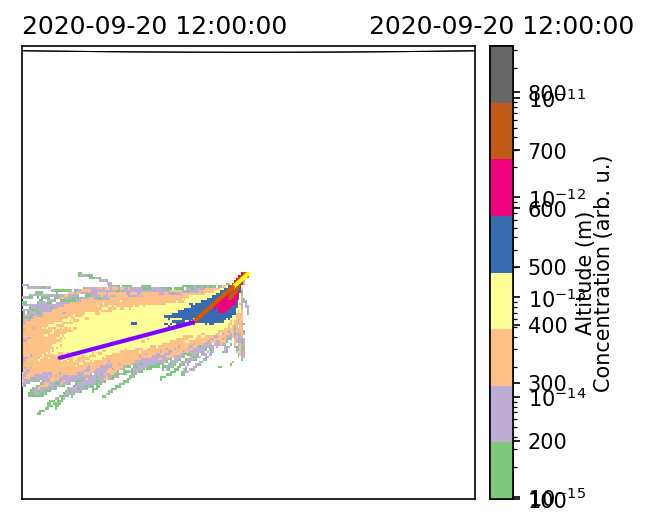

In [167]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon
bmap = Basemap(width=0.2e6,height=0.2e6,
            resolution='h',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
# bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)

if 1:
    outt = run_t.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)

if 1:
    outc = run_c.result.plot(bmap=bmap)


a = plt.gca()
a.set_title(run_t.parameters.start_time)

AxesSubplot
(15, 26)


/mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:886: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = a[a_idx].pcolormesh(xm_lon, ym_lat, z, zorder=50, norm=_LogNorm(),shading='auto',


Text(0.5, 1.0, '2020-09-20 12:00:00')

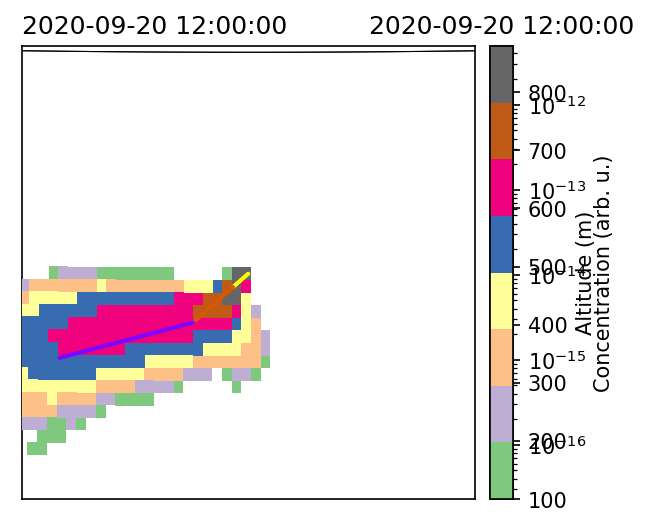

In [159]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon
bmap = Basemap(width=0.2e6,height=0.2e6,
            resolution='h',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
# bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)

if 1:
    outt = run_t.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)

if 1:
    outc = run_c.result.plot(bmap=bmap)


a = plt.gca()
a.set_title(run_t.parameters.start_time)

AxesSubplot
(4, 5)


/mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:886: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = a[a_idx].pcolormesh(xm_lon, ym_lat, z, zorder=50, norm=_LogNorm(),shading='auto',


Text(0.5, 1.0, '2020-09-20 13:00:00')

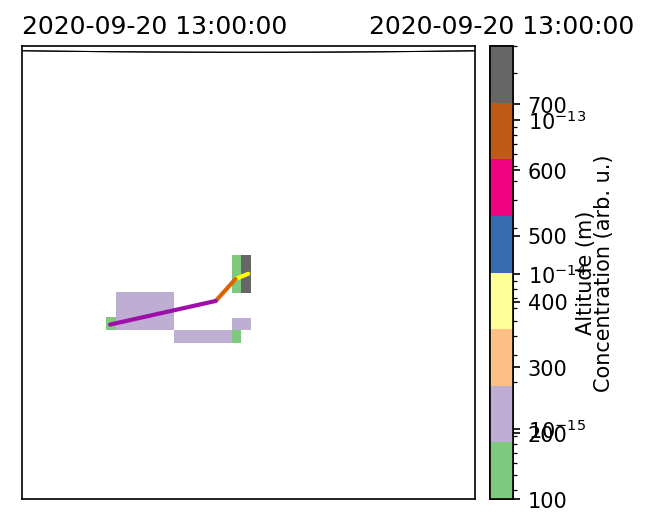

In [111]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon
bmap = Basemap(width=0.2e6,height=0.2e6,
            resolution='h',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
# bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)

if 1:
    outt = run_t.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)

if 1:
    outc = run_c.result.plot(bmap=bmap)


a = plt.gca()
a.set_title(run_t.parameters.start_time)

Text(0.5, 1.0, '2020-09-30 13:00:00')

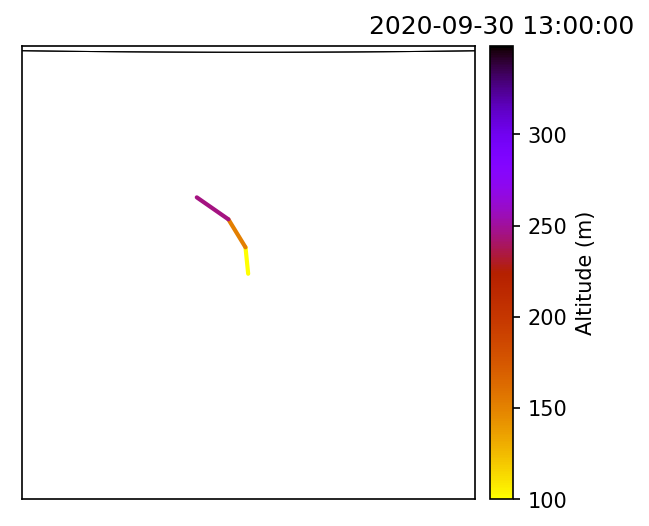

In [93]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:753
lat,lon = coordinates_lat_lon
bmap = Basemap(width=0.2e6,height=0.2e6,
            resolution='h',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
# bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)

if 1:
    outt = run_t.result.plot(bmap = bmap,
    #                          lat_c= center[0], lon_c=center[1],
    #                          w = 1e4, h = 1e4,
                                color_gradiant=plt.cm.gnuplot_r, scaley = False)
    _,_,lc,cb = outt
    lc.set_alpha(1)
    cb.set_label('Altitude (m)')
    lc.set_linewidth(2)
    lc.set_zorder(100)

if 0:
    outc = run_c.result.plot(bmap=bmap)


a = plt.gca()
a.set_title(run_t.parameters.start_time)

In [108]:
# run_c.parameters.start_time = start_time
run_c.download_missing_meterologic_files()

In [110]:
run_c.result.concentration

<xarray.DataArray (time: 1, latitude: 4, longitude: 5)>
array([[[    nan,     nan,     nan, 3.5e-16, 3.0e-13],
        [    nan, 1.1e-15,     nan,     nan,     nan],
        [4.7e-16, 1.2e-15,     nan, 1.2e-15, 1.4e-15],
        [    nan,     nan, 1.2e-15, 7.0e-16,     nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-20T00:10:00
  * latitude   (latitude) float64 40.12 39.97 39.92 39.87
  * longitude  (longitude) float64 -106.0 -105.9 -105.3 -105.3 -105.2

In [109]:
run_c.run()

In [82]:
run_c.result.concentration

<xarray.DataArray (time: 1, latitude: 1, longitude: 2)>
array([[[6.e-15, 2.e-12]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-30T00:10:00
  * latitude   (latitude) float64 40.12
  * longitude  (longitude) float64 -105.3 -105.2

## multi

In [22]:
reload(hysplit_py.split_lab)
reload(hysplit_py)

<module 'hysplit_py' from '/mnt/telg/prog/hysplit-py/hysplit_py/__init__.py'>

In [27]:
# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:651
# start at the end
test = True
startdt = run_info.copy()
# startdt = startdt[startdt.hy_mode == 'traj'].copy()


out = hysplit_py.split_lab.multirun(startdt,folders, process_number,
                                    test=test, 
#                verbose = True
              )
# out = multirun([run_c], startdt,save_base_folder, test=True)

20171206_000000_100m_traj.nc...filename exists -> skip
20171206_000000_1000m_conc.nc...done	stop since testing?


In [28]:
res = out[0]

AxesSubplot
(28, 30)


[<Figure size 900x600 with 2 Axes>,
 <AxesSubplot:title={'left':'2017-12-06 00:00:00'}>,

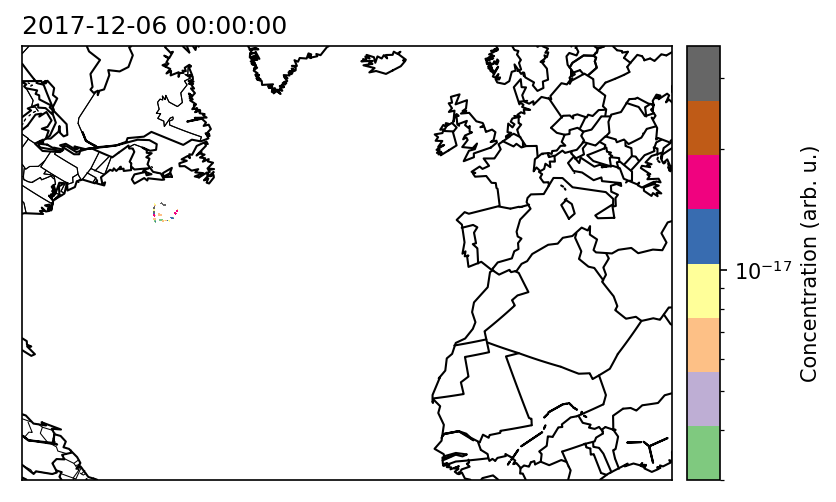

In [29]:
bla = 0.6e7
lat,lon = coordinates_lat_lon
bmap = Basemap(width=1.5 *bla,height=bla,
            resolution='c',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)
res.plot(bmap = bmap)

In [ ]:
bla = 0.6e7
lat,lon = coordinates_lat_lon
bmap = Basemap(width=1.5 *bla,height=bla,
            resolution='c',projection='aea',
#             lat_1=40.,lat_2=60,
               lon_0=lon,lat_0=lat)
bmap.drawcoastlines(linewidth = 1)
bmap.drawstates()
bmap.drawcountries(linewidth = 1)
res.plot(bmap = bmap)

In [32]:
print(res.run_settings)

concentration_grids     :  
default
--------
center                                       :  [39.0916, -28.0256]
output_path                                  :  ./cdump
sampling_interval                            :  [0, 240, 0]
sampling_start_time                          :  2017-12-06 00:00:00
sampling_stop_time                           :  2017-11-26 00:00:00
spacing                                      :  [0.05, 0.05]
span                                         :  [60.0, 360]
vertical_concentration_levels_height_of_each :  100
vertical_concentration_levels_number         :  1

input_met_data_folder   :  /mnt/data/data/hysplit_met_files/
input_met_file_names    :  ['20171206_gdas0p5', '20171205_gdas0p5', '20171204_gdas0p5', '20171203_gdas0p5', '20171202_gdas0p5', '20171201_gdas0p5', '20171130_gdas0p5', '20171129_gdas0p5', '20171128_gdas0p5', '20171127_gdas0p5', '20171126_gdas0p5']
meterologic_data_format :  gdas0p5
num_starting_loc        :  1
number_of_samples       :  100
output_

In [16]:
for idx, row in run_info.iterrows():
    break

In [18]:
'deposition_particle_diameter' in row.index

True

In [19]:
row

start_datetime                           2017-12-06 00:00:00
run_time                                                -240
lat                                                  39.0916
lon                                                 -28.0256
deposition_particle_diameter                             3.5
deposition_particle_density                              2.6
deposition_particle_shape                                1.3
altitude                                                 100
hy_mode                                                 traj
file_name                       20171206_000000_100m_traj.nc
Name: 0, dtype: object

In [ ]:
bla

In [ ]:
for res in out:
    res.plot()

In [ ]:
run_t.parameters

In [ ]:
run_c.parameters

# Dataworkup

## movie

In [ ]:
reload(hysplit_py.split_lab)

In [ ]:
save_base_folder

In [ ]:
res_dict = hysplit_py.open_result_netCDF(save_base_folder, raise_error=False)
# res_dict = hysplit_py.open_result_netCDF('/mnt/telg/tmp/edna/', raise_error=False)

In [ ]:
conc_kwargs =   dict(resolution='l', 
                     back_ground = 'bluemarble',
                     costlines=False, 
                     countries=False, 
                     states=False,
                     lat_c=coordinates_lat_lon[0], 
                     lon_c=coordinates_lat_lon[1] , 
                     w=7890244, 
                     h=6848458, 
                     zoom_out=2, 
                     colorbar=True,
                     plt_kwargs = {'vmin': 1e-19})

In [ ]:
res = res_dict[list(res_dict)[0]]
res.plot(**conc_kwargs)

In [ ]:
lumi = lume.read_file('/mnt/data/data/land_use_data/LCType_0p025.nc')
res_dict.land_use_map = lumi

# %%debug -b /mnt/telg/prog/hysplit-py/hysplit_py/split_lab.py:968
res_dict.source_attribution_landuse#.to_csv('/mnt/data/data/hysplit_products/ENA_IOP_201801_02/ENA_IOP_201801_02.01_overview/source_attribution_landuse.csv')
res_dict.source_attribution_angular#.to_csv('/mnt/data/data/hysplit_products/ENA_IOP_201801_02/ENA_IOP_201801_02.01_overview/source_attribution_angular.csv')

In [ ]:
outputfolder = '/mnt/data/data/hysplit_products/for_joe_2019/20190808_overwiew/'
fname = outputfolder + 'overveiw.mp4'
res_dict.create_movie_overview(fname, dpi = 200, 
                               test = False, 
                               conc_kwargs=conc_kwargs, 
                               save_figures2folder = outputfolder + 'figures/',
                               create_from_saved_figs = True,)

## from run_info

In [ ]:
reload(hysplit_py)
reload(hysplit_py.split_lab)

In [7]:
def get_bmap(a, low_res = False, 
#              scale = 1.2
            ):
    if low_res:
        res = 'c'
    else:
        res = 'i'
    lat,lon = coordinates_lat_lon
    wh = 5e6
#     f,a = plt.subplots(3)
    bmap = Basemap(ax = a,width=2 * wh,height=wh,
                resolution=res,projection='aea',
    #             lat_1=40.,lat_2=60,
                   lon_0=lon,lat_0=lat,
                  )
#     print(bmap)
    bmap.drawcoastlines(linewidth = 0.4)
    bmap.drawstates(linewidth = 0.2)
    bmap.drawcountries(linewidth = 0.4)
    bmap.bluemarble()
    
    return bmap

In [8]:
def plot_traj(traj,bmap, dt, alt, a):
    _,a,lc,cb = traj.plot(bmap= bmap, zorder = 60, color_gradiant=plt.cm.gnuplot_r)
    cb.set_label('Altitude above ground (m)')
    lc.set_clim(0,5e3)
    title = a.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
    
    return bmap, a, lc, cb

def plot_conc(conc, bmap, dt, alt,a):
#     a = plt.subplot()
#     bmap = get_bmap(a,low_res = True)
    f,a,_,pc,cb = conc.plot(bmap=bmap, plt_kwargs={})
    pc.set_clim(1e-19,1e-15)
    cm = copy.copy(plt.cm.get_cmap("gnuplot_r"))
    cm.set_under(color = [1,1,1,0])
    pc.set_cmap(cm)
    title = a.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
    return bmap, a, pc,cb
    

In [13]:
path2figs = '/mnt/data/data/hysplit_products/4Evguieni_ENA_dust/coarse_mode/201712/figures/'
path2figs = pathlib.Path(path2figs)
path2figs.mkdir(exist_ok=True)
# path2data = pathlib.Path('/mnt/data/data/hysplit_products/ENA_dust/201712/data/')

In [14]:
lumi = lume.read_file('/mnt/data/data/land_use_data/LCType_0p025.nc')


In [15]:
This one had a problem, try the one below
def plot_from_runinfo(what = 'conc', save = False, low_res = True, lumi = False, save_base_folder = save_base_folder, path2figs = path2figs, test = False, use_conc = None):

    ####################
    # traj = False
    # conc = True
    # assert(not (traj and conc)), 'only traj or conc'

    path2folder_res = pathlib.Path(save_base_folder)
    if what == 'source':
        f = plt.figure()
        f.set_figwidth(f.get_figwidth() * 1.7)
        no_rows = len(altitude)
        f.set_figheight(f.get_figheight() * no_rows)
        aa = []
        for i in range(no_rows):
            a_angle = f.add_subplot(no_rows,2,(i*2)+1,projection = 'polar')
            a_lu = f.add_subplot(no_rows,2,(i*2)+2, )
            aa.append([a_angle, a_lu])
    else:
        f, aa = plt.subplots(len(altitude), gridspec_kw={'hspace': 0.1})
        scale = 3
        f.set_figheight(f.get_figheight() * scale)
        f.set_figwidth(f.get_figwidth() * scale)
    for i,dt in enumerate(run_info.start_datetime.unique()):
        print(dt)
        st_df = run_info.loc[run_info.start_datetime == dt]

    #     f.clear()
        if what == 'source':
            for a in aa:
                for at in a:
                    at.clear()
        else:
            for a in aa:
                a.clear()

        for e,alt in enumerate(altitude):

            a = aa[e]
#             print(aa)
            if what != 'source':
                bmap = get_bmap(a, low_res = low_res)
            sa_df = st_df.loc[st_df.altitude == alt]

            if what == 'traj':
    #             assert(False)
                path2traj = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'traj'].file_name.iloc[0])

                # open file
                # 
                traj = hysplit_py.open_result_netCDF(path2traj)

                bmap, a, lc, cb = plot_traj(traj, bmap, dt, alt, a)
                # save figure
            #     p2f = path2figs.joinpath(path2traj.name.replace('.nc', '.png'))
            #     f.patch.set_alpha(0)
            #     f.savefig(p2f, dpi = 200, bbox_inches = 'tight')

            elif what == 'conc':
                path2conc = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'conc'].file_name.iloc[0])
                conc = hysplit_py.open_result_netCDF(path2conc)
                bmap, a, pc, cb = plot_conc(conc, bmap, dt, alt, a)
    #             assert(False)
            elif what == 'source':
                if isinstance(use_conc, type(None)):
                    path2conc = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'conc'].file_name.iloc[0])
                    conc = hysplit_py.open_result_netCDF(path2conc)
                    conc.source_attribution_land_use.land_use_map = lumi
                else:
                    conc = use_conc
                a_ang, a_lu = a
                conc.source_attribution_angular.plot(ax = a_ang)
                conc.source_attribution_land_use.plot(ax = a_lu, style='bar')
                # f.subplots_adjust(wspace  = 1)
                f.tight_layout()
                title = a_ang.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
#                 assert(False), 'test'
            else:
                assert(False), 'geht nich'

        if save:
            dt = pd.to_datetime(dt)
            name = f'{dt.year:04d}{dt.month:02d}{dt.day:02d}_{dt.hour:02d}{dt.minute:02d}{dt.second:02d}_{what}.png'
            p2ff = path2figs.joinpath(what)
            p2ff.mkdir(exist_ok=True)
            p2f = p2ff.joinpath(name)
            f.patch.set_alpha(0)
            f.savefig(p2f, dpi = 200, bbox_inches = 'tight')
        if test:
            assert(False)
#             if i == 2:
#                 break

    
            

In [23]:
def plot_from_runinfo(what = 'conc', save = False, low_res = True, lumi = False, save_base_folder = save_base_folder, path2figs = path2figs, test = False, use_conc = None):

    ####################
    # traj = False
    # conc = True
    # assert(not (traj and conc)), 'only traj or conc'

    path2folder_res = pathlib.Path(save_base_folder)
    if what == 'source':
        f = plt.figure()
        f.set_figwidth(f.get_figwidth() * 1.7)
        no_rows = len(altitude)
        f.set_figheight(f.get_figheight() * no_rows)
        aa = []
        for i in range(no_rows):
            a_angle = f.add_subplot(no_rows,2,(i*2)+1,projection = 'polar')
            a_lu = f.add_subplot(no_rows,2,(i*2)+2, )
            aa.append([a_angle, a_lu])
    else:
        f, aa = plt.subplots(len(altitude), gridspec_kw={'hspace': 0.1})
        scale = 3
        f.set_figheight(f.get_figheight() * scale)
        f.set_figwidth(f.get_figwidth() * scale)
    for i,dt in enumerate(run_info.start_datetime.unique()):
        print(dt)
        st_df = run_info.loc[run_info.start_datetime == dt]

    #     f.clear()
        if what == 'source':
            for a in aa:
                for at in a:
                    at.clear()
        else:
            for a in aa:
                a.clear()

        for e,alt in enumerate(altitude):

            a = aa[e]
#             print(aa)
            if what != 'source':
                bmap = get_bmap(a, low_res = low_res)
            sa_df = st_df.loc[st_df.altitude == alt]

            if what == 'traj':
    #             assert(False)
                path2traj = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'traj'].file_name.iloc[0])

                # open file
                # 
                traj = hysplit_py.open_result_netCDF(path2traj)

                bmap, a, lc, cb = plot_traj(traj, bmap, dt, alt, a)
                # save figure
            #     p2f = path2figs.joinpath(path2traj.name.replace('.nc', '.png'))
            #     f.patch.set_alpha(0)
            #     f.savefig(p2f, dpi = 200, bbox_inches = 'tight')

            elif what == 'conc':
                path2conc = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'conc'].file_name.iloc[0])
                conc = hysplit_py.open_result_netCDF(path2conc)
                try:
                    bmap, a, pc, cb = plot_conc(conc, bmap, dt, alt, a)
                except:
                    print('problem plotting concentration ... skip.')
                    continue
    #             assert(False)
            elif what == 'source':
                if isinstance(use_conc, type(None)):
                    path2conc = path2folder_res.joinpath(sa_df[sa_df.hy_mode == 'conc'].file_name.iloc[0])
                    conc = hysplit_py.open_result_netCDF(path2conc)
                    conc.source_attribution_land_use.land_use_map = lumi
                else:
                    conc = use_conc
                a_ang, a_lu = a
                conc.source_attribution_angular.plot(ax = a_ang)
                conc.source_attribution_land_use.plot(ax = a_lu, style='bar')
                # f.subplots_adjust(wspace  = 1)
                f.tight_layout()
                title = a_ang.set_title(f'{pd.to_datetime(dt)} - altitude: {alt: 4d} m', loc = 'left')
#                 assert(False), 'test'
            else:
                assert(False), 'geht nich'

        if save:
            dt = pd.to_datetime(dt)
            name = f'{dt.year:04d}{dt.month:02d}{dt.day:02d}_{dt.hour:02d}{dt.minute:02d}{dt.second:02d}_{what}.png'
            p2ff = path2figs.joinpath(what)
            p2ff.mkdir(exist_ok=True)
            p2f = p2ff.joinpath(name)
            f.patch.set_alpha(0)
            try:
                f.savefig(p2f, dpi = 200, bbox_inches = 'tight')
            except:
                print("problem with printing the figure ... skip")
                continue
        if test:
            assert(False)
#             if i == 2:
#                 break

    
            

2017-12-06T00:00:00.000000000
2017-12-06T03:00:00.000000000
2017-12-06T06:00:00.000000000
2017-12-06T09:00:00.000000000
2017-12-06T12:00:00.000000000
2017-12-06T15:00:00.000000000
2017-12-06T18:00:00.000000000
2017-12-06T21:00:00.000000000
2017-12-07T00:00:00.000000000
2017-12-07T03:00:00.000000000
2017-12-07T06:00:00.000000000
2017-12-07T09:00:00.000000000
2017-12-07T12:00:00.000000000
2017-12-07T15:00:00.000000000
2017-12-07T18:00:00.000000000
2017-12-07T21:00:00.000000000
2017-12-08T00:00:00.000000000
2017-12-08T03:00:00.000000000
2017-12-08T06:00:00.000000000
2017-12-08T09:00:00.000000000
2017-12-08T12:00:00.000000000
2017-12-08T15:00:00.000000000
2017-12-08T18:00:00.000000000
2017-12-08T21:00:00.000000000
2017-12-09T00:00:00.000000000
2017-12-09T03:00:00.000000000
2017-12-09T06:00:00.000000000
2017-12-09T09:00:00.000000000
2017-12-09T12:00:00.000000000
2017-12-09T15:00:00.000000000
2017-12-09T18:00:00.000000000
2017-12-09T21:00:00.000000000
2017-12-10T00:00:00.000000000
2017-12-10

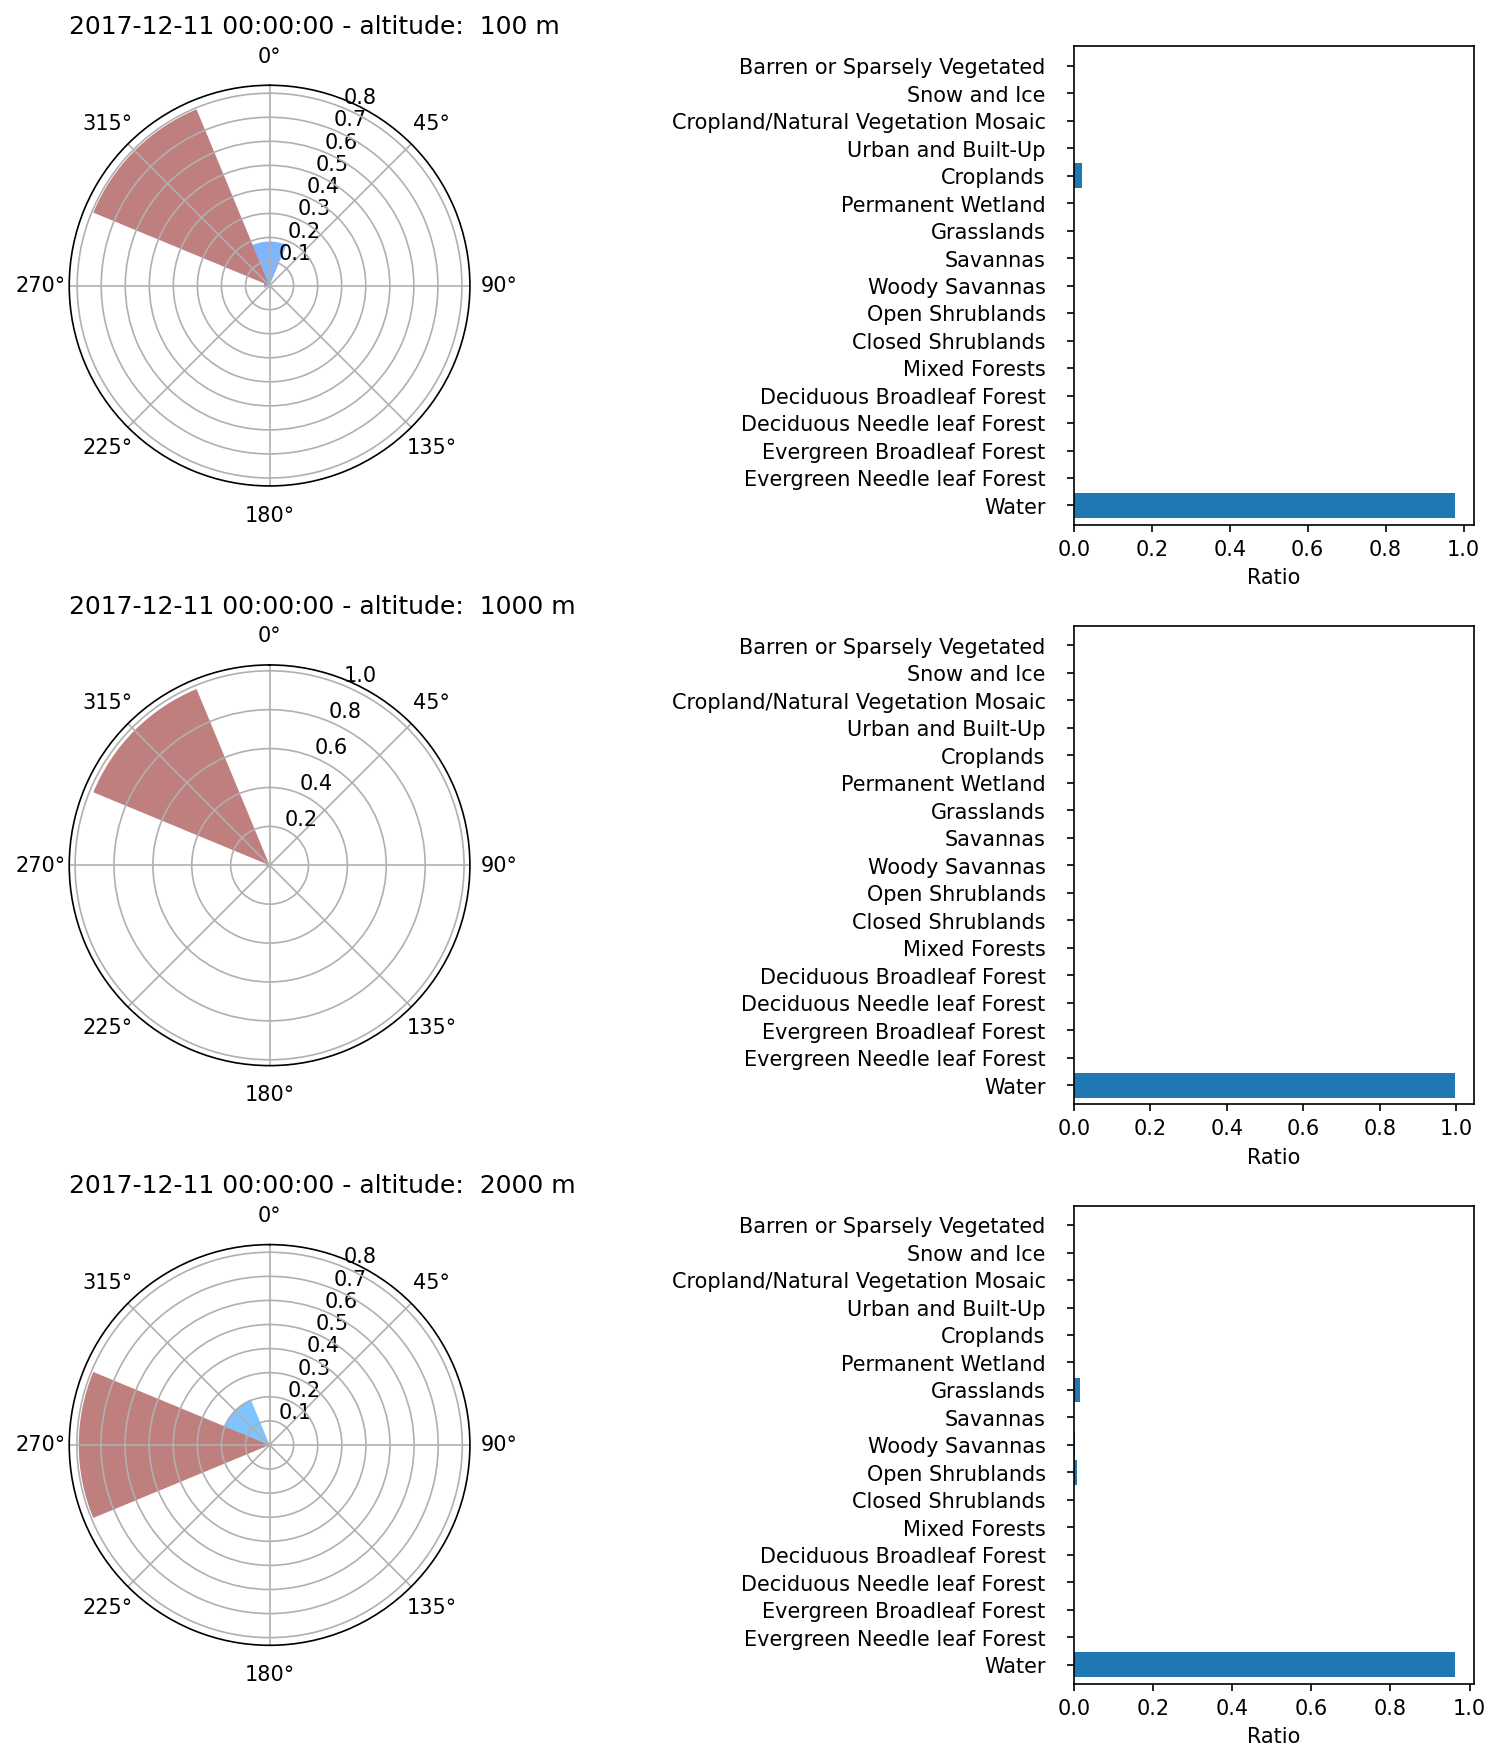

In [16]:
plot_from_runinfo(
    what='source',
#     save_base_folder=path2data,
    save=True,
#     low_res=False,
    test=False,
#     conc = conc,
    lumi = lumi)

2017-12-06T00:00:00.000000000
2017-12-06T03:00:00.000000000
2017-12-06T06:00:00.000000000
2017-12-06T09:00:00.000000000
2017-12-06T12:00:00.000000000
2017-12-06T15:00:00.000000000
2017-12-06T18:00:00.000000000
2017-12-06T21:00:00.000000000
2017-12-07T00:00:00.000000000
2017-12-07T03:00:00.000000000
2017-12-07T06:00:00.000000000
2017-12-07T09:00:00.000000000
2017-12-07T12:00:00.000000000
2017-12-07T15:00:00.000000000
2017-12-07T18:00:00.000000000
2017-12-07T21:00:00.000000000
2017-12-08T00:00:00.000000000
2017-12-08T03:00:00.000000000
2017-12-08T06:00:00.000000000
2017-12-08T09:00:00.000000000
2017-12-08T12:00:00.000000000
2017-12-08T15:00:00.000000000
2017-12-08T18:00:00.000000000
2017-12-08T21:00:00.000000000
2017-12-09T00:00:00.000000000
2017-12-09T03:00:00.000000000
2017-12-09T06:00:00.000000000
2017-12-09T09:00:00.000000000
2017-12-09T12:00:00.000000000
2017-12-09T15:00:00.000000000
2017-12-09T18:00:00.000000000
2017-12-09T21:00:00.000000000
2017-12-10T00:00:00.000000000
2017-12-10

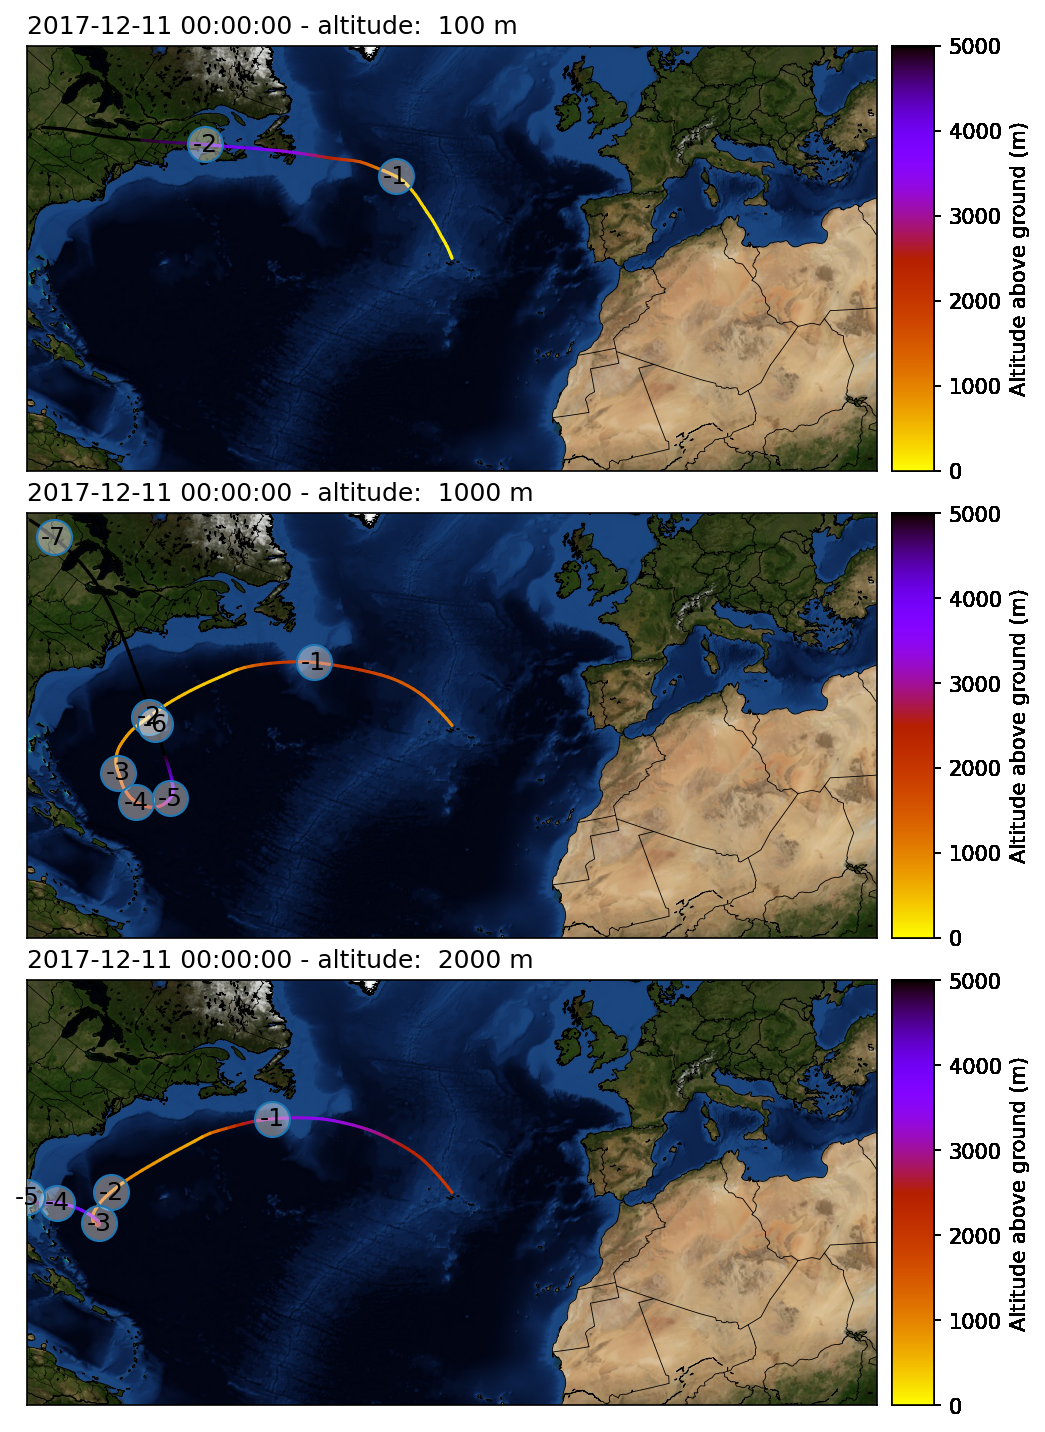

In [17]:
plot_from_runinfo(
    what='traj',
#     save_base_folder=path2data,
    save=True,
    low_res=False,
    test=False,)

2017-12-06T00:00:00.000000000
AxesSubplot
(677, 1366)
AxesSubplot
(320, 469)
AxesSubplot
(184, 232)
2017-12-06T03:00:00.000000000
AxesSubplot
(705, 1349)
AxesSubplot
(200, 279)
AxesSubplot
(216, 271)
2017-12-06T06:00:00.000000000
AxesSubplot
(796, 1507)
AxesSubplot
(623, 1244)
AxesSubplot
(0, 0)
2017-12-06T09:00:00.000000000
AxesSubplot
(796, 1924)
AxesSubplot
(595, 1186)
AxesSubplot
(472, 843)
2017-12-06T12:00:00.000000000
AxesSubplot
(747, 1963)
AxesSubplot
(753, 1910)
AxesSubplot
(322, 1151)
2017-12-06T15:00:00.000000000
AxesSubplot
(708, 1818)
AxesSubplot
(503, 1416)
AxesSubplot
(299, 1480)
2017-12-06T18:00:00.000000000
AxesSubplot
(566, 1416)
AxesSubplot
(591, 1646)
AxesSubplot
(345, 1085)
2017-12-06T21:00:00.000000000
AxesSubplot
(826, 1959)
AxesSubplot
(896, 1930)
AxesSubplot
(454, 727)
2017-12-07T00:00:00.000000000
AxesSubplot
(805, 2240)
AxesSubplot
(545, 1323)
AxesSubplot
(309, 855)
2017-12-07T03:00:00.000000000
AxesSubplot
(919, 2289)
AxesSubplot
(340, 718)
AxesSubplot
(185,

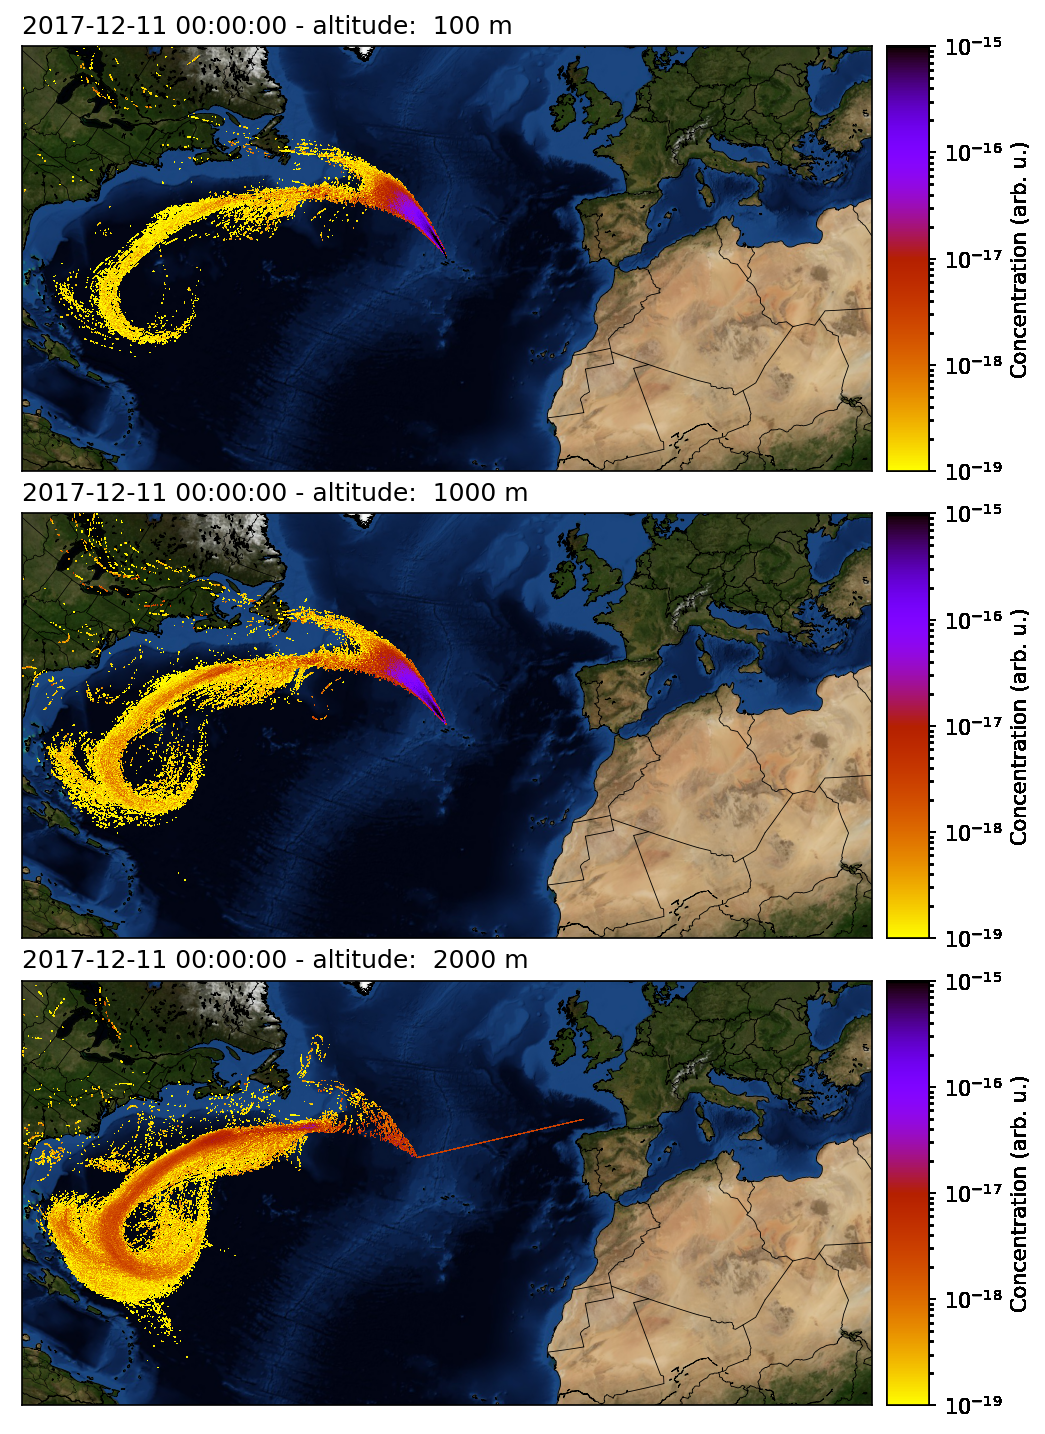

In [24]:
plot_from_runinfo(
    what='conc',
#     save_base_folder=path2data,
    save=True,
    low_res=False,
    test=False,)

### old

In [ ]:
path2folder_res = pathlib.Path(save_base_folder)

In [ ]:
alt = altitude[0]
file_list_traj = list(path2folder_res.glob(f'*{alt}m_traj*'))
file_list_conc = list(path2folder_res.glob(f'*{alt}m_conc*'))
file_list_traj.sort()
file_list_conc.sort()

In [ ]:
list(zip(file_list_traj, file_list_conc))[0]

In [ ]:
pathfold = '/mnt/data/data/hysplit_products/ENA_dust/201903/'
pathfold = pathlib.Path(pathfold)
fnamelist = list(pathfold.glob('*'))
fnamelist = list(np.unique(['_'.join(fn.name.split('_')[:2]) for fn in fnamelist]))

In [ ]:
i= 1
fname = pathfold.joinpath(fnamelist[i])
fn_conc = fname.as_posix()+'_conc.nc'
fn_traj = fname.as_posix()+'_traj.nc'
fn_conc

In [ ]:
conc = hysplit_py.open_result_netCDF(fn_conc)
traj = hysplit_py.open_result_netCDF(fn_traj)

In [ ]:
w = 3e6

outt = traj.plot(color_gradiant=plt.cm.cool,
                     resolution='c', 
                     back_ground = 'bluemarble',
                     zorder = 100, 
                     w = w, h=w)
bmap,_,_ = outt
out = conc.plot(bmap = bmap, 
                colorbar=False
               )
#                 lat_c=coordinates_lat_lon[0], 
#                 lon_c=coordinates_lat_lon[1],
#                 w = w, h= w)

lc = outt[2]

lc.set_alpha(1)

## from list

In [ ]:
from mpl_toolkits.basemap import Basemap

In [ ]:
plt.rcParams['figure.dpi'] = 100

In [ ]:
reload(hysplit_py)
reload(hysplit_py.split_lab)
reload(hysplit_py.split_lab._plt_tools.colorbar)

In [ ]:
pathfold = pathlib.Path('/mnt/data/data/hysplit_products/for_joe_2019/march/20200121/data/')#20141202_194437_conc.nc')
pathfoldout = pathlib.Path('/mnt/data/data/hysplit_products/for_joe_2019/march/20200121/figure_traj/')

In [ ]:
test = False
w = 3e6
concentation = False
if test:
    res = 'c'
    xpixels = 100
    dpi = 50
else:
    res = 'i'
    xpixels = 1000
    dpi = 100

In [ ]:
df

In [ ]:
import warnings

In [ ]:
overwrite = False
lat,lon = coordinates_lat_lon

for idx in df.index.unique():
    if 0:
        if idx != 13:
            continue
              
    sel = df.loc[idx,:].sort_values('start_times')


    f,aa = plt.subplots(1,3)
    f.set_size_inches(f.get_size_inches()*3)
    i = -1
    fnameout = None
    for ix, row in sel.iterrows():
        i+=1
    #     pass
    #     i= 1
        a = aa[i]

        fname = pathfold.joinpath(str(row.start_times).replace('-','').replace(':', '').replace(' ','_'))
        fn_conc = fname.as_posix()+'_conc.nc'
        fn_traj = fname.as_posix()+'_traj.nc'
        print(fname)


#         if concentation:
            
        if not pathlib.Path(fn_traj).is_file():
            if i == 1:
                warnings.warn('The center file ({}) was missing ... no figure created'.format(pathlib.Path(fn_traj).name))
                break
            else:
                warnings.warn('File {} missing ... there will be plot missing'.format(pathlib.Path(fn_traj).name))
                continue
                
        traj = hysplit_py.open_result_netCDF(fn_traj)

        # bgfname = '/'
        bmap = Basemap(resolution = res,
                       width=w, height=w*2,
                      llcrnrlon=lon-28,llcrnrlat=lat-12,urcrnrlat=79,urcrnrlon=-35,
        #               lat_0=71.2906, lon_0=156.7886,
                      epsg = 3572,
                      ax = a)
        #     llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, epsg=5520)
        #http://server.arcgisonline.com/arcgis/rest/services


        outt = traj.plot(bmap = bmap,
                        color_gradiant=plt.cm.gnuplot_r,
                             resolution=res, 
        #                      back_ground = 'bluemarble',
                             zorder = 100, 
                             w = w, h=w,
                          colorbar = {'position': 'bottom',
                                     'pad':0.2},
                          verbose = False)
        bmap,_,lc,cb = outt
        lc.set_alpha(1)
        cb.set_label('Altitude (m)')
        lc.set_linewidth(2)
        
        if concentation:
            conc = hysplit_py.open_result_netCDF(fn_conc)
            out = conc.plot(bmap = bmap, 
                            colorbar=False
                           )
            a = out[1]
        
        parallels = np.arange(0.,81,5.)
        latmax = 85
        bmap.drawparallels(parallels,labels=[False,True,True,False], latmax=latmax)
        
        meridians = np.arange(10.,351.,20.)
        bmap.drawmeridians(meridians,labels=[True,False,False,True], latmax=latmax)

        if  1:
            bmap.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = xpixels, verbose= True)
            bmap.drawcoastlines(linewidth=0.5)
            
        dt = row.start_times
        tposx = 0.05
        tposy = 0.92
        if i == 1:
            fnameout = '{:04d}{:02d}{:02d}_{:02d}{:02d}{:02d}.png'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
            a.text(tposx, tposy, dt, size = 14, zorder = 200, transform = a.transAxes,
                  bbox=dict(boxstyle="round",
#                             ec=(1., 0.5, 0.5)
                            fc = [1,1,1,0.5]
#                             alpha = 0.5
                           )
                  )
        if i==0:
            tt = '- 1 day'
            a.text(tposx, tposy, tt, size = 14, zorder = 200, transform = a.transAxes,
                    bbox=dict(boxstyle="round",
        #                             ec=(1., 0.5, 0.5)
                            fc = [1,1,1,0.5]
        #                             alpha = 0.5
                           )
                  )
        elif i==2:
            tt = '+ 1 day'
            a.text(tposx, tposy, tt, size = 14, zorder = 200, transform = a.transAxes,
                    bbox=dict(boxstyle="round",
        #                             ec=(1., 0.5, 0.5)
                            fc = [1,1,1,0.5]
        #                             alpha = 0.5
                           )
                  )
            
        
    # in case the center file is missing ... continue
    if isinstance(fnameout, type(None)):
        continue
#         continue
    pathout = pathfoldout.joinpath(fnameout)
    if not overwrite:
        if pathout.is_file():
            print('file {} exists ... skip'.format(pathout.name))
    
    f.patch.set_alpha(0)
#     a.set_axis_off()
#     f.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#     a.margins(0,0)
    f.savefig(pathout, dpi = dpi, bbox_inches = 'tight',
#               pad_inches = 0,
             )
    if test:
        assert(False)


In [ ]:
import plt_tools

In [ ]:
plt_tools.colorbar.colorbar_axis_split_off()

In [ ]:
f.colorbar()

# era interim files

In [ ]:
from ecmwfapi import ECMWFDataServer    

In [ ]:
server = ECMWFDataServer()

In [ ]:
server.retrieve({
    'stream'    : "oper",
    'levtype'   : "sfc",
    'param'     : "165.128/166.128",
    'dataset'   : "interim",
    'step'      : "0",
    'grid'      : "0.75/0.75",
    'time'      : "18",
    'date'      : "2012-07-20/2012-07-21/2013-02-23/2013-02-24",
    'type'      : "an",
    'class'     : "ei",
    'format'    : "netcdf",
    'target'    : "TCAP2goldendays_v10u10_ext.nc"
 })

In [ ]:
from erainterim import era_lab as el

In [ ]:
reload(el)

In [ ]:
fname = fname = '/Volumes/HTelg_4TB_Backup/era_interim_files/TCAP2goldendays_v10u10_ext.nc'
erant4 = el.load_nc(fname)

In [ ]:
fname = fname = '/Volumes/HTelg_4TB_Backup/era_interim_files/TCAP2goldendays_v10u10.nc'
erant2 = el.load_nc(fname)

In [ ]:
f,a,sl,cb = erant4.wind_10.plot_streamlines(3, vmin = 0, vmax = 18)

In [ ]:
f,a = plt.subplots(2,3)
# f.set_size_inches(f.get_size_inches() * 2)
f.set_figwidth(20)
f.set_figheight(11)
((as1,as2,as3),(aw1,aw2,aw3)) = a

vmin = 0
vmax = 18
erant4.wind_10.plot_streamlines(0,ax = as1, vmin = vmin, vmax = vmax)
erant4.wind_10.plot_streamlines(1,ax = as2, vmin = vmin, vmax = vmax)
erant2.wind_10.plot_streamlines(0,ax = as3, vmin = vmin, vmax = vmax)

erant4.wind_10.plot_streamlines(2,ax = aw1, vmin = vmin, vmax = vmax)
erant4.wind_10.plot_streamlines(3,ax = aw2, vmin = vmin, vmax = vmax)
erant2.wind_10.plot_streamlines(1,ax = aw3, vmin = vmin, vmax = vmax)
